In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [123]:
import pandas as pd

train = pd.read_csv('../data/preliminary/train.csv')
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240000 entries, 0 to 239999
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             240000 non-null  int64  
 1   trans_date_trans_time  240000 non-null  object 
 2   cc_num                 240000 non-null  int64  
 3   merchant               240000 non-null  object 
 4   category               240000 non-null  object 
 5   amt                    240000 non-null  float64
 6   first                  240000 non-null  object 
 7   last                   240000 non-null  object 
 8   gender                 240000 non-null  object 
 9   street                 240000 non-null  object 
 10  city                   240000 non-null  object 
 11  state                  240000 non-null  object 
 12  zip                    240000 non-null  int64  
 13  lat                    240000 non-null  float64
 14  long                   240000 non-nu

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,1072349,2020-03-21 19:05:27,2242542703101233,fraud_Bahringer Group,health_fitness,1.40,Samuel,Jenkins,M,43235 Mckenzie Views Apt. 837,Westport,KY,40077,38.4921,-85.4524,564,Pensions consultant,1996-04-10,5a4c5bc47fd9ca60a9cdbe38423654b4,1363892727,37.965322,-85.661501,0
1,1123019,2020-04-12 21:34:21,4469777115158234880,"fraud_Douglas, Schneider and Turner",shopping_pos,9.73,Gregory,Graham,M,4005 Dana Glens,Methuen,MA,1844,42.7280,-71.1810,47249,Market researcher,1980-11-22,af686a90fb3eff86e0a961d852550619,1365802461,43.044230,-71.136907,0
2,1287799,2020-06-17 16:24:29,4312133045694601139,fraud_Fritsch and Sons,health_fitness,21.84,Julian,Price,M,086 Pierce Cove,Pikesville,MD,21208,39.3764,-76.7290,33917,Company secretary,1977-06-12,f70fea505c5a765825aafb72d18c1aa5,1371486269,39.365746,-77.165503,0
3,640815,2019-09-29 19:34:07,30029052116970,fraud_Wiza LLC,misc_pos,8.16,Curtis,Young,M,4319 Watson Shoals Suite 658,Falconer,NY,14733,42.1239,-79.1895,3833,Metallurgist,1970-10-09,61d6b585be9cad4fd36409019b693aaa,1348947247,42.692928,-78.435859,0
4,668880,2019-10-12 14:38:12,3500969075198072,fraud_Predovic Inc,shopping_net,184.55,Kenneth,Sanchez,M,0110 Ashley Forest,Tekoa,WA,99033,47.2271,-117.0819,895,Clothing/textile technologist,1999-05-31,e7fc0dc8be81974dacd6fc4c7e3c5362,1350052692,47.861069,-116.983182,0


In [124]:
# split train df, validation df, test df into each of their X and y
y_train = train.pop('is_fraud')
X_train = train

In [125]:
# X_train['cc_num'] = X_train['cc_num'].astype(str)

# X_train['cc_length'] = X_train['cc_num'].apply(len)

# length_counts = X_train['cc_length'].value_counts().sort_index()

# print("Counts of each credit card number length:")
# print(length_counts)

In [126]:
BIN_DATABASE = {
    "4": "Visa",
    "51": "MasterCard", "52": "MasterCard", "53": "MasterCard", "54": "MasterCard", "55": "MasterCard",
    "34": "American Express", "37": "American Express",
    "6011": "Discover", "65": "Discover", "622126": "Discover", "622925": "Discover",
    "3528": "JCB", "3589": "JCB",
}

def extract_card_info(card_number):
    """
    Extract useful information from a credit card number.
    :param card_number: str - The credit card number to analyze
    :return: dict - Dictionary containing various pieces of information
    """
    card_info = {}
    
    # Step 1: Ensure input is a string
    card_number = str(card_number).strip()
    
    # Step 2: Validate the card number length
    length = len(card_number)
    card_info['length'] = length
    
    # Step 3: Identify the card issuer
    issuer = "Unknown"
    for prefix in BIN_DATABASE:
        if card_number.startswith(prefix):
            issuer = BIN_DATABASE[prefix]
            break
    card_info['issuer'] = issuer
    
    # Step 4: Validate using Luhn algorithm
    def luhn_algorithm(card_number):
        digits = [int(d) for d in card_number][::-1]
        checksum = 0
        for i, digit in enumerate(digits):
            if i % 2 == 1:
                digit *= 2
                if digit > 9:
                    digit -= 9
            checksum += digit
        return checksum % 10 == 0
    
    card_info['luhn_valid'] = luhn_algorithm(card_number)
    
    # Step 5: Major Industry Identifier (MII)
    mii_map = {
        '1': "Airlines",
        '2': "Airlines",
        '3': "Travel and Entertainment",
        '4': "Banking and Financial",
        '5': "Banking and Financial",
        '6': "Merchandising and Banking",
        '7': "Petroleum",
        '8': "Telecommunications",
        '9': "National Assignment",
    }
    mii = mii_map.get(card_number[0], "Unknown Industry")
    card_info['mii'] = mii
    
    # Step 6: Card Level (if applicable, for AMEX or others)
    card_info['card_level'] = "Standard"  # Default value
    if issuer == "American Express":
        card_info['card_level'] = "Gold or Platinum" if length == 15 else "Standard"
    
    # Step 7: Validate Length (as a preliminary check)
    valid_length = {
        "Visa": [13, 16, 19],
        "MasterCard": [16],
        "American Express": [15],
        "Discover": [16, 19],
        "JCB": [15, 16]
    }
    if issuer in valid_length and length not in valid_length[issuer]:
        card_info['length_valid'] = False
    else:
        card_info['length_valid'] = True
    
    return card_info

# Example usage with a DataFrame
def analyze_credit_cards(df, column='cc_num'):
    """
    Analyze credit card numbers in a DataFrame and extract useful information,
    adding the results directly to the DataFrame.
    :param df: DataFrame containing credit card numbers
    :param column: str - Name of the column containing credit card numbers
    """
    # Create an empty DataFrame to hold results
    results = []
    
    for card_number in df[column]:
        card_info = extract_card_info(card_number)
        results.append(card_info)
    
    # Convert results to DataFrame and concatenate directly to X_train
    df_results = pd.DataFrame(results)
    for col in df_results.columns:
        df[col] = df_results[col]

# Analyze credit card numbers in the DataFrame
analyze_credit_cards(X_train)

In [127]:
X_train

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,length,issuer,luhn_valid,mii,card_level,length_valid
0,1072349,2020-03-21 19:05:27,2242542703101233,fraud_Bahringer Group,health_fitness,1.40,Samuel,Jenkins,M,43235 Mckenzie Views Apt. 837,Westport,KY,40077,38.4921,-85.4524,564,Pensions consultant,1996-04-10,5a4c5bc47fd9ca60a9cdbe38423654b4,1363892727,37.965322,-85.661501,16,Unknown,True,Airlines,Standard,True
1,1123019,2020-04-12 21:34:21,4469777115158234880,"fraud_Douglas, Schneider and Turner",shopping_pos,9.73,Gregory,Graham,M,4005 Dana Glens,Methuen,MA,1844,42.7280,-71.1810,47249,Market researcher,1980-11-22,af686a90fb3eff86e0a961d852550619,1365802461,43.044230,-71.136907,19,Visa,True,Banking and Financial,Standard,True
2,1287799,2020-06-17 16:24:29,4312133045694601139,fraud_Fritsch and Sons,health_fitness,21.84,Julian,Price,M,086 Pierce Cove,Pikesville,MD,21208,39.3764,-76.7290,33917,Company secretary,1977-06-12,f70fea505c5a765825aafb72d18c1aa5,1371486269,39.365746,-77.165503,19,Visa,True,Banking and Financial,Standard,True
3,640815,2019-09-29 19:34:07,30029052116970,fraud_Wiza LLC,misc_pos,8.16,Curtis,Young,M,4319 Watson Shoals Suite 658,Falconer,NY,14733,42.1239,-79.1895,3833,Metallurgist,1970-10-09,61d6b585be9cad4fd36409019b693aaa,1348947247,42.692928,-78.435859,14,Unknown,True,Travel and Entertainment,Standard,True
4,668880,2019-10-12 14:38:12,3500969075198072,fraud_Predovic Inc,shopping_net,184.55,Kenneth,Sanchez,M,0110 Ashley Forest,Tekoa,WA,99033,47.2271,-117.0819,895,Clothing/textile technologist,1999-05-31,e7fc0dc8be81974dacd6fc4c7e3c5362,1350052692,47.861069,-116.983182,16,Unknown,True,Travel and Entertainment,Standard,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239995,589692,2019-09-07 16:09:20,4079773899158,fraud_Waelchi Inc,kids_pets,12.88,Eric,Preston,M,7020 Doyle Stream Apt. 951,Mesa,ID,83643,44.6255,-116.4493,129,Cartographer,1965-12-15,5dbc1fa717e840c81823e095d955bbbf,1347034160,44.798352,-116.632527,13,Visa,True,Banking and Financial,Standard,True
239996,314690,2019-06-01 06:52:28,180064817343047,"fraud_Schuppe, Nolan and Hoeger",shopping_pos,1.63,Patricia,Gonzalez,F,8973 Mark Drive,Stephensport,KY,40170,37.9048,-86.5240,344,Chartered public finance accountant,1967-03-30,8eaf8a4778b3e680c65d518543926b06,1338533548,38.157359,-85.857702,15,Unknown,True,Airlines,Standard,True
239997,1194213,2020-05-13 20:14:00,30408301059761,fraud_Hilpert-Conroy,kids_pets,40.69,Brandon,Pittman,M,2881 Frey Village,Cross,SC,29436,33.3364,-80.1859,4471,Occupational hygienist,1973-10-09,d8b06bc69af2831cbd158ab5ca7bd200,1368476040,33.821302,-81.055067,14,Unknown,True,Travel and Entertainment,Standard,True
239998,1073052,2020-03-22 02:48:25,38057513087029,fraud_Luettgen PLC,gas_transport,47.25,Marissa,Clark,F,2677 Byrd Village Suite 035,San Jose,CA,95148,37.3304,-121.7913,973849,Geoscientist,1997-01-18,3100d31fbc201be7bdd07faa0ee1d37b,1363920505,38.272782,-122.041386,14,Unknown,True,Travel and Entertainment,Standard,True


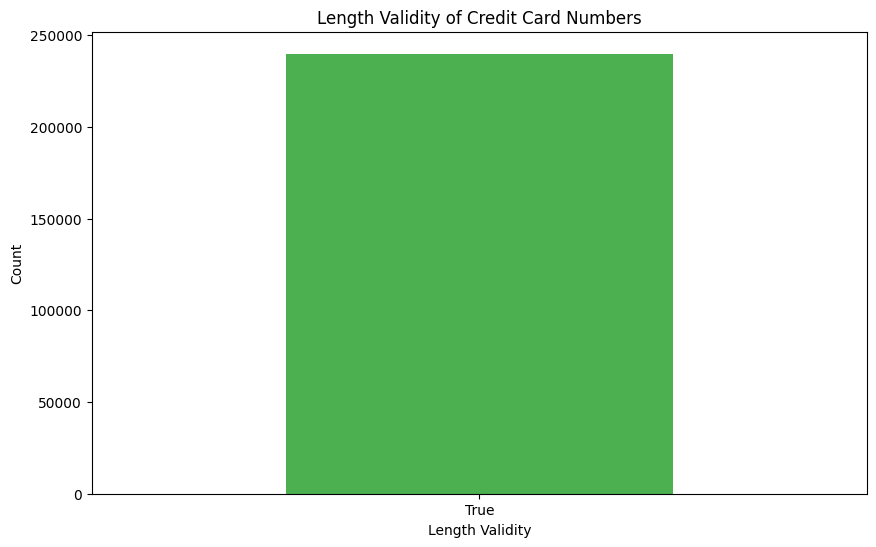

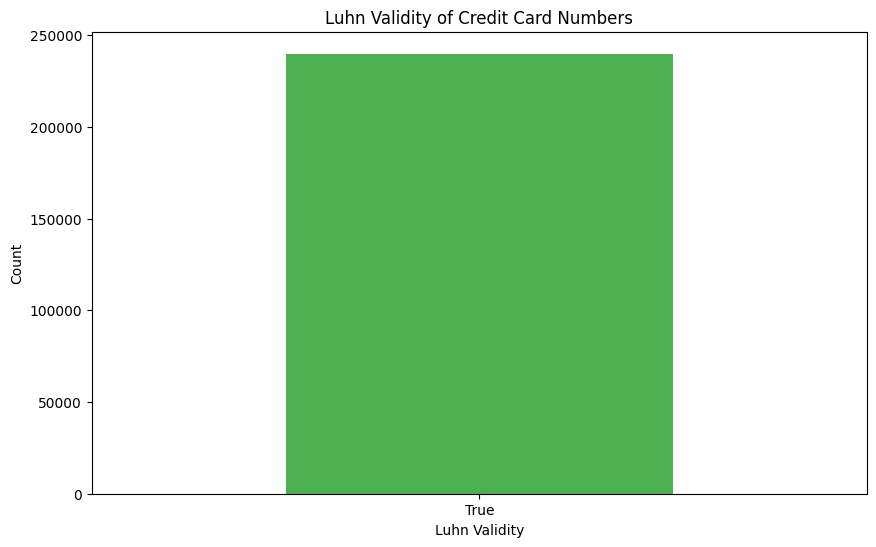

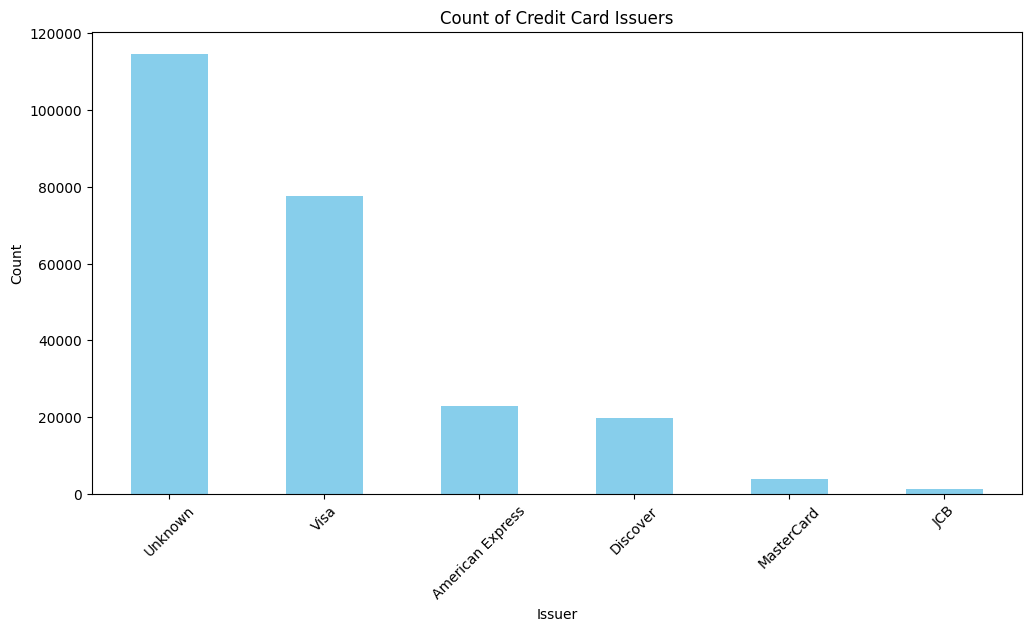

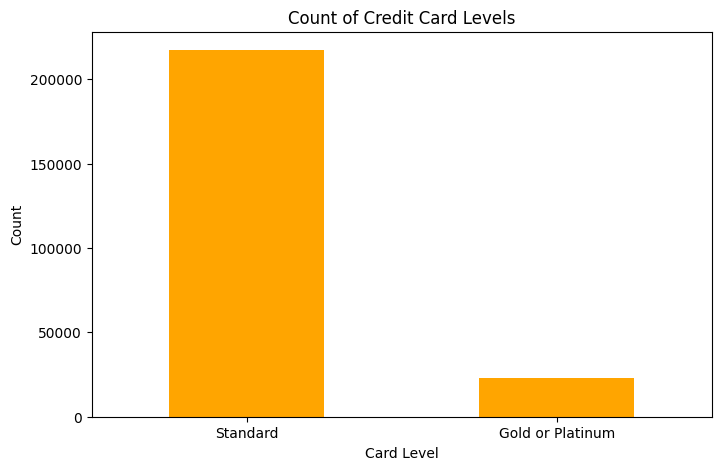

In [128]:
plt.style.use('default')  # or you can use 'ggplot', 'classic', etc.

# Length Validity Plot
plt.figure(figsize=(10, 6))
length_valid_counts = X_train['length_valid'].value_counts()
length_valid_counts.plot(kind='bar', color=['#4CAF50', '#FF5733'])
plt.title('Length Validity of Credit Card Numbers')
plt.xlabel('Length Validity')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


# Length Validity Plot
plt.figure(figsize=(10, 6))
length_valid_counts = X_train['luhn_valid'].value_counts()
length_valid_counts.plot(kind='bar', color=['#4CAF50', '#FF5733'])
plt.title('Luhn Validity of Credit Card Numbers')
plt.xlabel('Luhn Validity')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


# Issuer Counts Plot
plt.figure(figsize=(12, 6))
issuer_counts = X_train['issuer'].value_counts()
issuer_counts.plot(kind='bar', color='skyblue')
plt.title('Count of Credit Card Issuers')
plt.xlabel('Issuer')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Card Level Counts Plot
plt.figure(figsize=(8, 5))
card_level_counts = X_train['card_level'].value_counts()
card_level_counts.plot(kind='bar', color='orange')
plt.title('Count of Credit Card Levels')
plt.xlabel('Card Level')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [129]:
# from geopy.distance import geodesic

# # Function to calculate distance between two coordinates
# def calculate_distance(row):
#     user_coords = (row['lat'], row['long'])
#     merchant_coords = (row['merch_lat'], row['merch_long'])
#     return geodesic(user_coords, merchant_coords).km

# # Apply this to each row in the dataset to create a 'distance' column
# X_train['distance'] = X_train.apply(calculate_distance, axis=1)


In [130]:
from geopy.distance import geodesic

# Ensure DataFrame is sorted by 'cc_num' and 'unix_time' before processing
X_train.sort_values(by=['cc_num', 'unix_time'], inplace=True)

# Add an index column to preserve original order
X_train['original_order'] = X_train.index

# Calculate the time since the last transaction without affecting original order
def calculate_time_diff(series):
    return series.diff().fillna(0)  # Fill NaN with 0 for the first transaction

X_train['time_since_last_trans'] = (
    X_train.groupby('cc_num')['unix_time']
    .transform(calculate_time_diff)
)

# Vectorized Distance Calculation
def calculate_previous_distance(group):
    # Get coordinates of previous transactions
    user_lat = group['lat'].shift(1)
    user_long = group['long'].shift(1)
    merchant_lat = group['merch_lat'].shift(1)
    merchant_long = group['merch_long'].shift(1)

    # Calculate distance using geodesic for the previous transaction
    distances = [
        geodesic((user_lat.iloc[i], user_long.iloc[i]), (merchant_lat.iloc[i], merchant_long.iloc[i])).km
        if i > 0 else 0.0  # For the first transaction
        for i in range(len(group))
    ]
    
    return pd.Series(distances)

# Apply the distance calculation function to each group
X_train['dist_from_last_trans'] = (
    X_train.groupby('cc_num')
    .apply(calculate_previous_distance)
).reset_index(drop=True)

# Calculate speed based on the previous distance
X_train['speed'] = np.where(
    X_train['time_since_last_trans'] > 0,
    X_train['dist_from_last_trans'] / (X_train['time_since_last_trans'] / 3600),  # Convert seconds to hours for speed in km/h
    0  # Speed is 0 if time difference is 0
)

# Sort the DataFrame back to its original order using the 'original_order' column
X_train.sort_values(by='original_order', inplace=True)

# Drop the 'original_order' column after sorting
X_train.drop(columns=['original_order'], inplace=True)

# Now X_train has 'time_since_last_trans' and 'dist_from_last_trans' with the original order maintained.


In [131]:
pd.set_option('display.max_columns', None)
# X_train[['cc_num', 'unix_time', 'lat', 'long', 'merch_lat', 'merch_long', 'dist_from_last_trans', 'time_since_last_trans', 'speed']][X_train['cc_num'] == 60416207185]

In [132]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler

def preprocess_data(df, drop_columns=None, scale_columns=None, encode_columns=None):
    """
    Preprocess the DataFrame for modeling.
    
    :param df: DataFrame to preprocess
    :param drop_columns: List of columns to drop from the DataFrame
    :param scale_columns: List of columns to scale
    :param encode_columns: List of columns to encode (one-hot encoding)
    :return: Preprocessed DataFrame
    """
    # Step 1: Drop specified columns
    if drop_columns is not None:
        df = df.drop(columns=drop_columns, errors='ignore')

    # Step 2: Handle missing values (for this example, we'll fill NaNs with a specific value)
    # You can modify this behavior based on your needs
    df.fillna(method='ffill', inplace=True)  # Forward fill, can be changed

    # Step 3: One-hot encode specified categorical columns
    if encode_columns is not None:
        df = pd.get_dummies(df, columns=encode_columns, drop_first=True)

    # Step 4: Scale specified numerical columns
    if scale_columns is not None:
        scaler = StandardScaler()
        df[scale_columns] = scaler.fit_transform(df[scale_columns])

    return df

# Example usage
# Specify columns to drop, scale, and encode
columns_to_drop = ['cc_num', 'trans_date_trans_time', 'merchant', 'category', 'first', 'last', 'street', 'state', 'job', 'dob', 'trans_num', 'luhn_valid', 'length_valid', 'gender', 'city']  # Drop original credit card numbers
columns_to_scale = ['length']  # Example numerical column
columns_to_encode = ['issuer', 'mii', 'card_level']  # Example categorical columns

# Preprocess the X_train DataFrame
X_train_processed = preprocess_data(X_train, drop_columns=columns_to_drop, 
                                     scale_columns=columns_to_scale, 
                                     encode_columns=columns_to_encode)

# Display the processed DataFrame
X_train_processed.head()
X_train = X_train_processed


In [133]:
X_train

,Unnamed: 0,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,length,time_since_last_trans,dist_from_last_trans,speed,issuer_Discover,issuer_JCB,issuer_MasterCard,issuer_Unknown,issuer_Visa,mii_Banking and Financial,mii_Merchandising and Banking,mii_Travel and Entertainment,card_level_Standard
0,1072349,1.40,40077,38.4921,-85.4524,564,1363892727,37.965322,-85.661501,0.348215,75432.0,0.000000,0.000000,False,False,False,True,False,False,False,False,True
1,1123019,9.73,1844,42.7280,-71.1810,47249,1365802461,43.044230,-71.136907,2.112184,28393.0,127.629296,16.182350,False,False,False,False,True,True,False,False,True
2,1287799,21.84,21208,39.3764,-76.7290,33917,1371486269,39.365746,-77.165503,2.112184,96068.0,110.202992,4.129687,False,False,False,False,True,True,False,False,True
3,640815,8.16,14733,42.1239,-79.1895,3833,1348947247,42.692928,-78.435859,-0.827765,5665.0,87.124420,55.365916,False,False,False,True,False,False,False,True,True
4,668880,184.55,99033,47.2271,-117.0819,895,1350052692,47.861069,-116.983182,0.348215,165406.0,65.357502,1.422482,False,False,False,True,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239995,589692,12.88,83643,44.6255,-116.4493,129,1347034160,44.798352,-116.632527,-1.415755,116411.0,99.299565,3.070830,False,False,False,False,True,True,False,False,True
239996,314690,1.63,40170,37.9048,-86.5240,344,1338533548,38.157359,-85.857702,-0.239775,15716.0,45.774492,10.485376,False,False,False,True,False,False,False,False,True
239997,1194213,40.69,29436,33.3364,-80.1859,4471,1368476040,33.821302,-81.055067,-0.827765,162550.0,72.854251,1.613505,False,False,False,True,False,False,False,True,True
239998,1073052,47.25,95148,37.3304,-121.7913,973849,1363920505,38.272782,-122.041386,-0.827765,188563.0,82.323889,1.571708,False,False,False,True,False,False,False,True,True


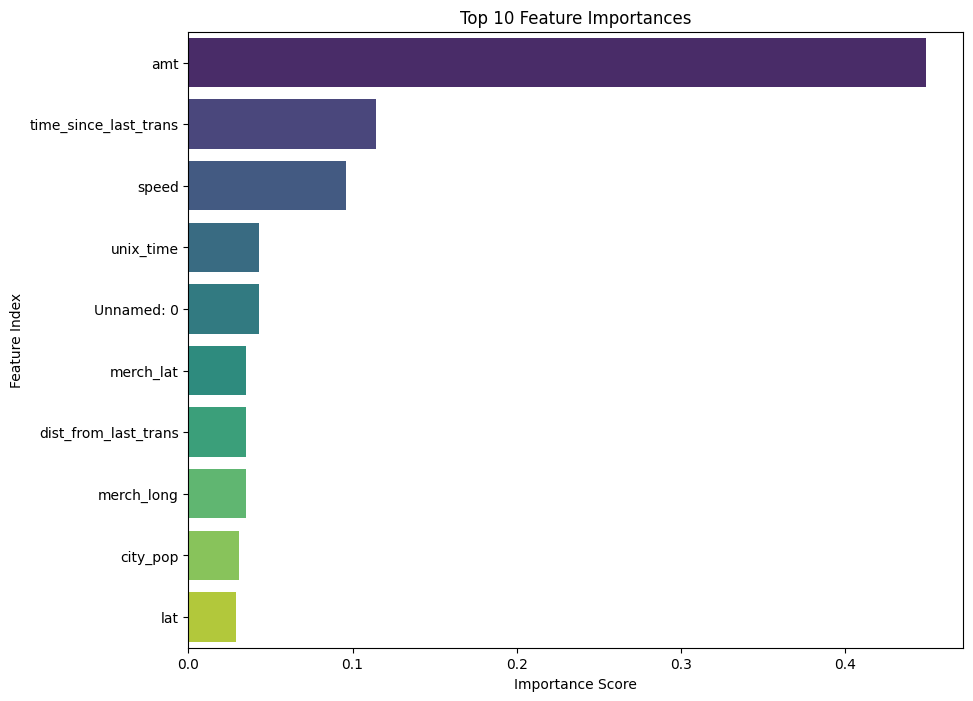

In [134]:
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
RANDOM_STATE = 42

X = X_train
y = y_train

# Train the Random Forest model
model = RandomForestClassifier(random_state=RANDOM_STATE)
model.fit(X, y)

# Get feature importances
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Set the number of top features to display
top_n = 10

# Create a horizontal bar plot for the top K features
plt.figure(figsize=(10, 8))
sns.barplot(x=importances[indices][:top_n], y=X.columns[indices][:top_n], palette='viridis')
plt.title(f"Top {top_n} Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature Index")
plt.show()

# X_train_reduced = X_train.iloc[:, indices[:top_n]]


In [137]:
print(indices)

[ 1 10 12  6  0  7 11  8  5  3  2  4  9 16 20 18 17 19 21 13 15 14]
